In [120]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


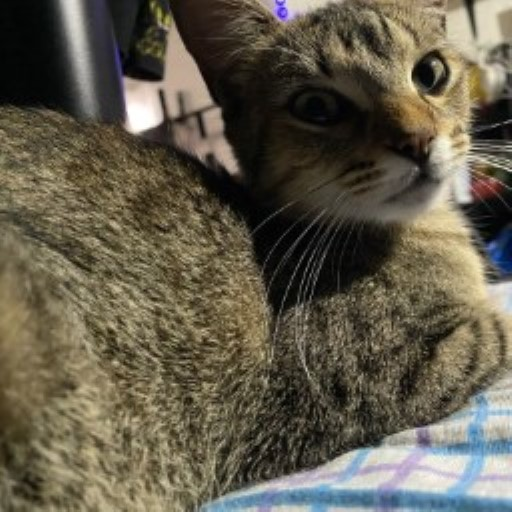

In [125]:
#Se lee la imagen

#imgOriginal = Image.open("../boy.png")
imgOriginal = Image.open("morgana.jpg")

imgOriginal


In [122]:
#Definición de funciones 

#Funcion que calcula la transformada rapida discreta de Fourier
def FFT(x):
    """
    A recursive implementation of 
    the 1D Cooley-Tukey FFT, the 
    input should have a length of 
    power of 2. 
    """
    N = len(x)
    
    if N == 1:
        return x
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j*np.pi*np.arange(N)/ N)
        
        
       
        
        X = np.concatenate([X_even+factor[:int(N/2)]*X_odd,
                            X_even+factor[int(N/2):]*X_odd])
        return X


#Funcion que calcula la transformada inversa rapida discreta de Fourier
def IFFT(x):
    """
    A recursive implementation of 
    the 1D Cooley-Tukey IFFT, the 
    input should have a length of 
    power of 2. 
    """
    N = len(x)
    
    if N == 1:
        return x
    else:
        X_even = IFFT(x[::2])
        X_odd = IFFT(x[1::2])
        factor = np.exp(2j*np.pi*np.arange(N)/ N)
        
        # Redimensionar X_even y X_odd según la forma de los factores
        X_even = np.resize(X_even, factor[:int(N/2)].shape)
        X_odd = np.resize(X_odd, factor[int(N/2):].shape)
        
        X = np.concatenate([X_even+factor[:int(N/2)]*X_odd,
                            X_even+factor[int(N/2):]*X_odd])
        return X
    
#Funcion que calcula la transformada rapida discreta de Fourier en 2D
def FFT2D(matrix):
    """
    Perform the 2D FFT on a matrix 
    by applying the 1D FFT on the 
    rows and then on the columns.
    """
    row = np.zeros(matrix.shape, dtype=complex)
    for i in range(matrix.shape[0]):
        row[i,:] = FFT(matrix[i,:])
        
    col = np.zeros(matrix.shape, dtype=complex)
    for i in range(matrix.shape[1]):
        col[:,i] = FFT(row[:,i])
        
    return col

#Funcion que calcula la transformada inversa rapida discreta de Fourier en 2D
def IFFT2D(matrix):
    """
    Perform the 2D Inverse FFT on a matrix 
    by applying the 1D IFFT on the 
    rows and then on the columns.
    """
    row = np.zeros(matrix.shape, dtype=complex)
    for i in range(matrix.shape[0]):
        row[i,:] = IFFT(matrix[i,:])
        
    col = np.zeros(matrix.shape, dtype=complex)
    for i in range(matrix.shape[1]):
        col[:,i] = IFFT(row[:,i])
        
    return col

#Función que hace el desplazamiento de la imagen, para que las frecuencias bajas queden en el centro
def fftshift(matriz):
    n = len(matriz)
    m = n // 2

    # Crear una nueva matriz para almacenar el resultado
    resultado = [[0j for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(n):
            # Calcular las nuevas coordenadas para el punto central
            new_i = (i + m) % n
            new_j = (j + m) % n
            # Asignar el valor del punto original a la nueva posición
            resultado[new_i][new_j] = matriz[i][j]

    return np.array(resultado)


#Función que hace el desplazamiento de la imagen, para que las frecuencias bajas otra vez en las esquinas, es la inversa de fftshift
def ifftshift(matriz):
    n = len(matriz)
    m = n // 2

    # Crear una nueva matriz para almacenar el resultado
    resultado = [[0j for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(n):
            # Calcular las coordenadas originales para el punto central
            orig_i = (i - m) % n
            orig_j = (j - m) % n
            # Asignar el valor del punto con shift a la posición original
            resultado[orig_i][orig_j] = matriz[i][j]

    return np.array(resultado)


#Funicón que grafica los espectros de frecuencia de cada canal de color
def plotearEspectros(espectroR, espectroG, espectroB):
    # Calcular los espectros de frecuencias para cada canal de color, es decir, la magnitud de cada canal
    espectro_rojo = np.abs(espectroR)
    espectro_verde = np.abs(espectroG)
    espectro_azul = np.abs(espectroB)

    # Aplicar una transformación logarítmica a cada espectro de frecuencias, para que se visualicen mejor los valores
    espectro_rojo_log = np.log(1 + espectro_rojo)
    espectro_verde_log = np.log(1 + espectro_verde)
    espectro_azul_log = np.log(1 + espectro_azul)

    # Mostrar los espectros de frecuencias para cada canal de color
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.imshow(espectro_rojo_log, cmap='gray')
    plt.title('Espectro de frecuencias - Rojo')
    plt.subplot(132)
    plt.imshow(espectro_verde_log, cmap='gray')
    plt.title('Espectro de frecuencias - Verde')
    plt.subplot(133)
    plt.imshow(espectro_azul_log, cmap='gray')
    plt.title('Espectro de frecuencias - Azul')
    plt.show()
    
    
#Función que reconstruye la imagen a partir de los espectros de frecuencias
def reconstruirImagen(espectroR, espectroG, espectroB):    
    # Reconstruir cada canal de color a partir de los espectros de frecuencias,a través de la transformada inversa de Fourier
    rojo_reconstruido = IFFT2D(espectroR)
    verde_reconstruido = IFFT2D(espectroG)
    azul_reconstruido = IFFT2D(espectroB)

    #Se normalizan los valores de la matriz
    maxR = np.max(rojo_reconstruido)
    maxG = np.max(verde_reconstruido)
    maxB = np.max(azul_reconstruido)

    rojo_reconstruido = (rojo_reconstruido/maxR) * 255
    verde_reconstruido = (verde_reconstruido/maxG) * 255
    azul_reconstruido = (azul_reconstruido/maxB) * 255
    
    
    #Se recortan los valores que no estan entre 0 y 255
    rojo_reconstruido = np.clip(np.real(rojo_reconstruido), 0, 255)
    verde_reconstruido = np.clip(np.real(verde_reconstruido), 0, 255)
    azul_reconstruido = np.clip(np.real(azul_reconstruido), 0, 255)



    #Se muestran los canaes de color reconstruidos
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.imshow(rojo_reconstruido, cmap='gray')
    plt.title('Canal rojo')
    plt.subplot(132)
    plt.imshow(verde_reconstruido, cmap='gray')
    plt.title('Canal verde')
    plt.subplot(133)
    plt.imshow(azul_reconstruido, cmap='gray')
    plt.title('Canal azul')
    plt.show()
    
    
    # Combinar los canales de color reconstruidos en una imagen RGB final
    imagen_reconstruida = np.dstack((rojo_reconstruido, verde_reconstruido, azul_reconstruido)).astype(int)

    # Mostrar la imagen reconstruida
    plt.imshow(imagen_reconstruida)
    plt.title('Imagen reconstruida')
    plt.show()
    

#Función que comprime la imagen, eliminando frecuencias altas, img es la imagen original y c es el porcentaje de compresión
def comprimirImagen(img, c):

    #obtener los canales de color de la imagen
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    # Aplicar la FFT a cada canal de color
    fft_rojo = FFT2D(R)
    fft_verde = FFT2D(G)
    fft_azul = FFT2D(B)
    
    
    
    #Se desplaza el espectro de frecuencias, para que las frecuencias más importantes queden en el centro
    fft_rojo = fftshift(fft_rojo)
    fft_azul = fftshift(fft_azul)
    fft_verde = fftshift(fft_verde)

  
    #Se calcula el total de pixeles de la imagen
    totalPixeles = imgOriginal.shape[0] * imgOriginal.shape[1]
    
    #Se calcula el total de pixeles que se van a comprimir(eliminar de la imagen)
    totalComprimido = totalPixeles * c

    #Para comprimir la imagen se debe elimir frecuencias altas, por lo que se debe eliminar pixeles que roodean el centro del espectro de frecuencias
    #Por lo tanto el centro del espectro de frecuencias quedará intacto, y se eliminaran los pixeles que lo rodean, el area que se salvará es un cuadrado
    #El lado de este cuadrado es la raiz cuadrada del total de pixeles que se van a eliminar, porque así, el area del cuadrado es igual a la cantidad de los pixeles que se van a eliminar
    lado = int(np.sqrt(totalComprimido))
    
    #Se recorre la matriz que representa el espectro de frecuencias, y se eliminan los pixeles que no estan en el cuadrado
    for i in range(imgOriginal.shape[0]):
        for j in range(imgOriginal.shape[1]):
            #solo el cuadrado de lado x lado se mantiene, el resto se hace 0
            #El cuadrado debe estar centrado en la imagen
            if not ((i >= imgOriginal.shape[0] // 2 - lado // 2 and i < imgOriginal.shape[0] // 2 + lado // 2) and (j >= imgOriginal.shape[1] // 2 - lado // 2 and j < imgOriginal.shape[1] // 2 + lado // 2)):
                fft_rojo[i][j] = 0 
                fft_verde[i][j] = 0 
                fft_azul[i][j] = 0 
    
    #Se grafican los espectros despues de comprimir
    plotearEspectros(fft_rojo, fft_verde, fft_azul)
    
    #Se desplaza el espectro para que quede como estaba antes de comprimir
    fft_rojo = ifftshift(fft_rojo)
    fft_verde = ifftshift(fft_verde)
    fft_azul = ifftshift(fft_azul)
    
    #Se reconstruye la imagen a partir de los espectros de frecuencias
    reconstruirImagen(fft_rojo, fft_verde, fft_azul)

def imprimirTitulo(titulo):
    # Crear una figura y un conjunto de ejes
    fig, ax = plt.subplots()
    fig.set_size_inches(4, 0.1)
    ax.axis('off')
    ax.set_title(titulo)
    plt.show()

    



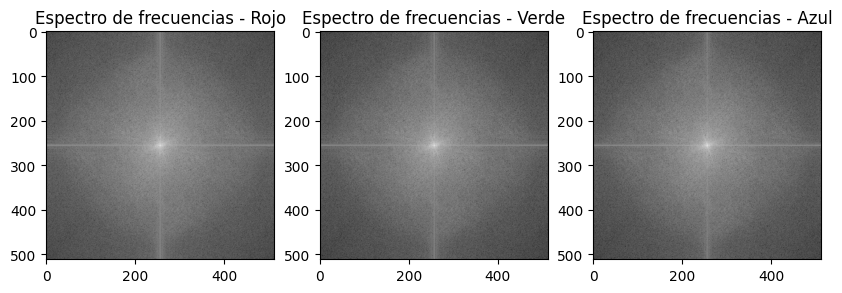

In [123]:
#Se convierte la imagen a un array y se guarda cada canal en una variable

imgOriginal = np.array(imgOriginal, dtype=int)
R = imgOriginal[:,:,0]
G = imgOriginal[:,:,1]
B = imgOriginal[:,:,2]

plotearEspectros(fftshift(FFT2D(R)), fftshift(FFT2D(G)), fftshift(FFT2D(B)))

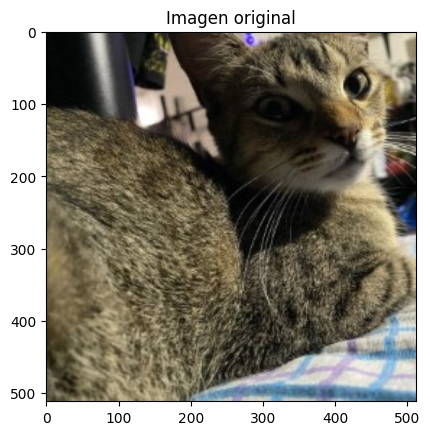

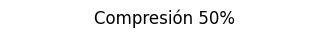

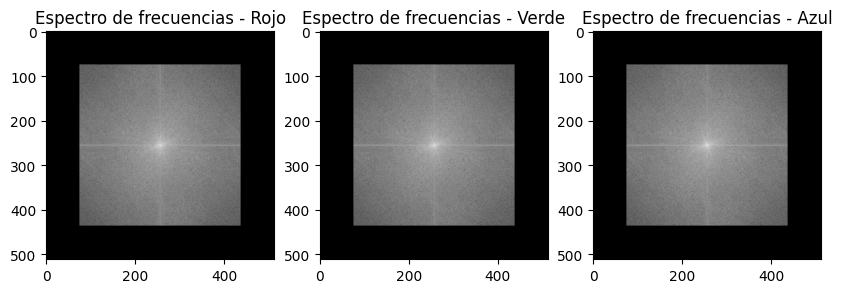

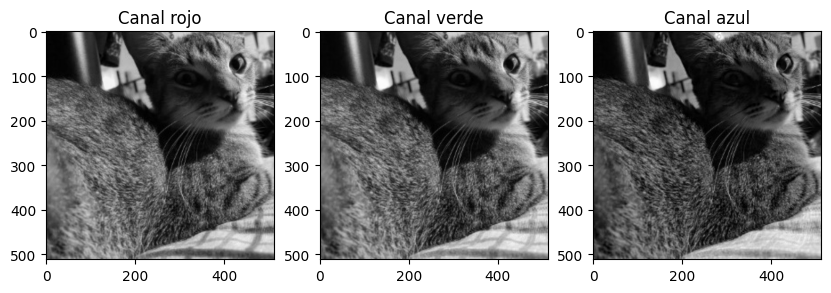

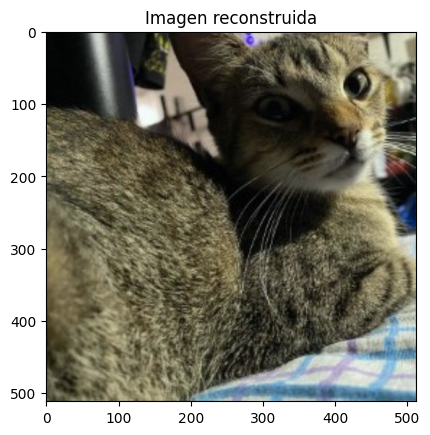

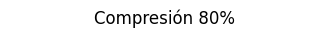

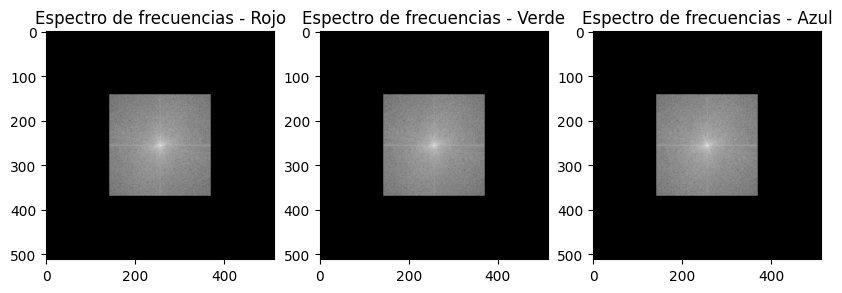

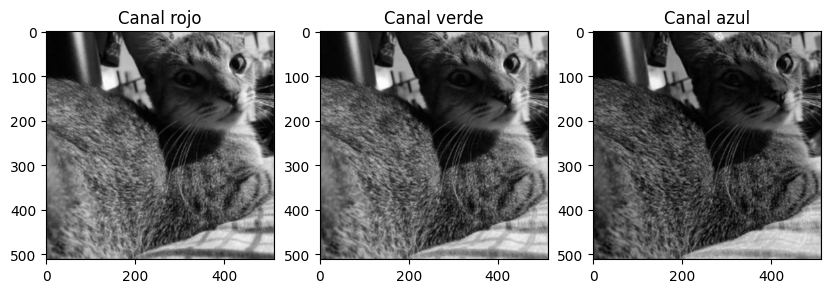

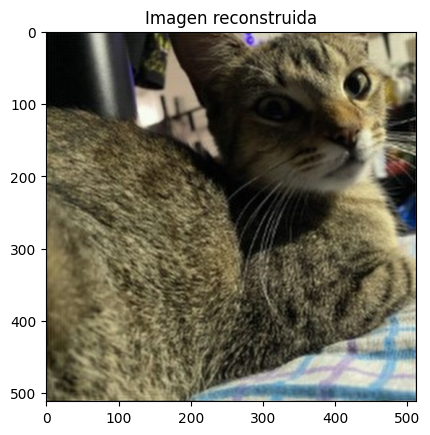

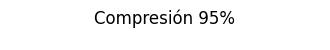

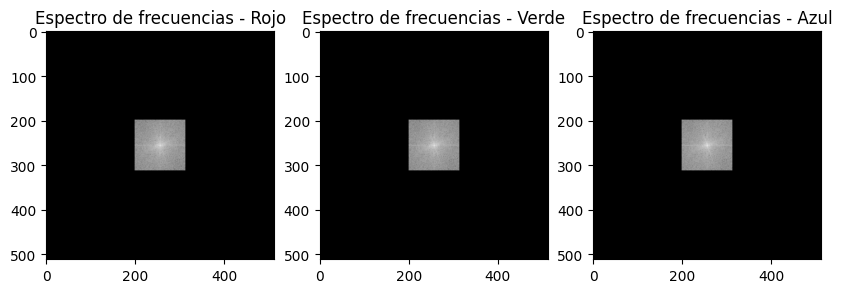

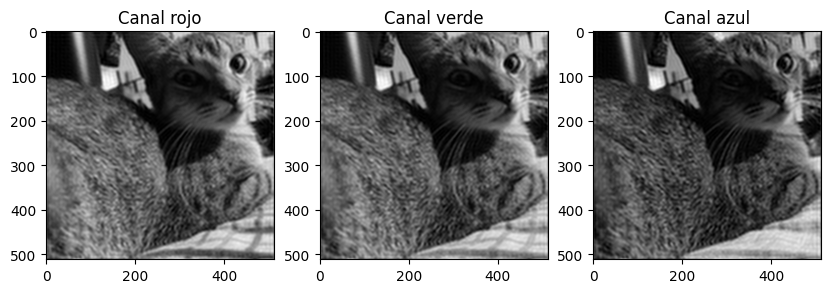

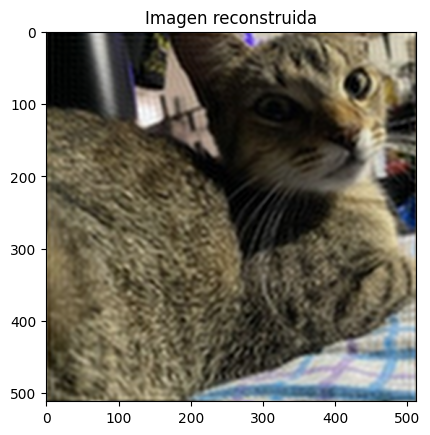

In [124]:
plt.title('Imagen original')
plt.imshow(imgOriginal)
plt.show()

imprimirTitulo('Compresión 50%')
comprimirImagen(imgOriginal, 0.5)

imprimirTitulo('Compresión 80%')
comprimirImagen(imgOriginal, 0.2)

imprimirTitulo('Compresión 95%')
comprimirImagen(imgOriginal, 0.05)